# Libraries and Settings

### Libraries

In [1]:
##########==========##########==========##########==========##########==========
## import libraries
import numpy  as np 
import pandas as pd
import matplotlib.pyplot as plt


## import functions from libraries
from docx     import Document
from os       import listdir
from datetime import datetime
from fastkml  import KML, Placemark

## import functions from library modules
from shapely.geometry  import MultiLineString
from matplotlib.colors import hsv_to_rgb, to_hex
from cartopy.crs       import LambertConformal

## define general purpose functions
def run_silently(func, arg):
    import sys, os
    so = sys.stdout
    sys.stdout = open(os.devnull, 'w')
    result = func(arg)
    sys.stdout = so
    return result

def time_check(id = 'X'):
    now = datetime.now()
    h   = now.hour
    m   = now.minute
    s   = now.second
    now = 'Time Check ' + id + ': ' + str(h) + ':' + str(m) + ':' + str(s)
    print('\n', now, '\n')
    
time_check('[Start]')


 Time Check [Start]: 14:19:32 



### Settings

In [2]:
## set visual parameters
set_color = {
    'Foreground': (0/12, 0.00, 0.0),
    'Background': (7/12, 0.05, 1.0),
    'Divider':    (7/12, 1.00, 0.5),

    'Coast':      (7/12, 0.50, 0.7),
    'Border':     (1/12, 0.05, 0.8),
    'Land':       (1/12, 0.05, 1.0),

    'Photo':      (1/12, 0.80, 0.3),
    'Visit':      (1/12, 0.80, 0.6),
    'Unvisit':    (1/12, 0.20, 1.0)
}

set_fontsize = {'L':48, 'M':24, 'S':12}

set_bbox = {}

## set tech parameters
set_core = {}

set_cache = {}

## set map parameters
set_map = {'all_opportunity': False,
    'extent': [-124.73 + 5, -66.95 - 5, 25.12 - 3.3, 49.38 + 3.3],
    'projection': LambertConformal(
        central_longitude = (-124.73 - 66.95) / 2,
        central_latitude = (25.12 + 49.38) / 2,
        standard_parallels = (25.12, 49.38)
        )
    }

## unpack color parameters
for i in set_color.keys():
    set_color[i] = to_hex(hsv_to_rgb(set_color[i]))

# Import Data

### Import Docx

In [3]:
## import a docx
def import_docx(address):
    from docx import Document
    txt = Document(address).paragraphs
    txt = [i.text for i in txt]
    txt = '\n'.join(txt)
    return txt

## import many docx in parallel
def import_all_docx(address):
    add_file = listdir(address)
    add_file = [address + i for i in add_file if i[-4:] == 'docx']
    all_txt = []
    for i in add_file:
        all_txt.append(import_docx(i))
    return(all_txt)

## execute functions
imported_docx = import_all_docx('A_Input/paragraph_text/')

### Import Xlsx

In [4]:
## import list of US cities to see
col_list = {'City':str, 'State':str, 'Route':str, 'Visit':int, 'Photo':int,
             'Score':int, 'lon':float, 'lat':float}
city_roster = pd.read_excel('A_Input/city_list.xlsx', sheet_name = 'Cities',
    usecols = col_list.keys(), dtype = col_list)

## import list of travel routes
col_list = {'route':str, 'pre_travel':str, 'drive_mileage':int, 'trip_days':int,
               'best_temp_1':str, 'best_temp_2':str, 'states_etc':str}
route_roster = pd.read_excel('A_Input/city_list.xlsx', sheet_name = 'Routes',
    usecols = col_list.keys(), dtype = col_list)

## optional: resets opportunity map to count all cities, regardless of visits
if set_map['all_opportunity']:
    city_roster['Score'] = 2
    city_roster['Visit'] = 0
    city_roster['Photo'] = 0

### Import Kml

In [5]:
## read in kml files
def import_kml(address):
    with open(address, 'rt', encoding = 'utf-8') as conn:
        raw_text = conn.read().encode('utf-8')
        parsed_kml = KML()
        parsed_kml.from_string(raw_text)
        conn.close()
    return parsed_kml

## process kml files
def process_kml(kml_object):
    
    ## extract route names
    get_name_attr = lambda a: a.name
    def extract_name(x):
        if len(list(x.features())) > 1:
            y = x.features()
            y = [get_name_attr(i) for i in y]
            return y
        else:
            return extract_name(list(x.features())[0])
    kml_name = extract_name(kml_object)
    
    ## extract route lines
    def extract_line(x):
        if isinstance(x, Placemark):
            return x.geometry
        else:
            return [extract_line(i) for i in x.features()]
    kml_line = extract_line(kml_object)
    
    ## extract line from superfluous nesting
    def unnest(x):
        if len(x) == 1:
            return unnest(x[0])
        else:
            return x
    kml_line = unnest(kml_line)
    
    ## merge lines that are part of the same route
    kml_line = [MultiLineString(i) for i in kml_line]
    
    ## package routes with names
    kml_line_dict = dict()
    for i in range(len(kml_name)):
        kml_line_dict[kml_name[i]] = kml_line[i]
        
    return kml_line_dict
    

## execute functions
route_kml  = import_kml('A_Input/Wishlist.kml')
route_kml  = process_kml(route_kml)

travel_kml = import_kml('A_Input/Travels.kml')
travel_kml = process_kml(travel_kml)

### Enrich Data

In [6]:
def enrich_route(route = route_roster, city = city_roster.copy()):
    
    ## round mileage to nearest 50 miles
    route['mileage'] = (np.round(route['drive_mileage'] / 50) * 50).astype(int)
    
    ## score each route for opportunities to advance towards goal
    route_score = city[['Route', 'Score']].groupby('Route').sum()
    route_score = route.join(route_score, on = 'route')['Score']
    route['score'] = route_score
    
    ## order routes into table order
    route = route[['route', 'mileage', 'trip_days', 'best_temp_1',
        'best_temp_2', 'score', 'pre_travel', 'states_etc', 'drive_mileage']]
    
    return route

## execute
route_roster = enrich_route(route_roster)

# Dashboard Architecture

### Style

In [7]:
## computations
def define_style():
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Quicksand']
    plt.rcParams['font.weight'] = 'medium'
    
define_style()

### Layout

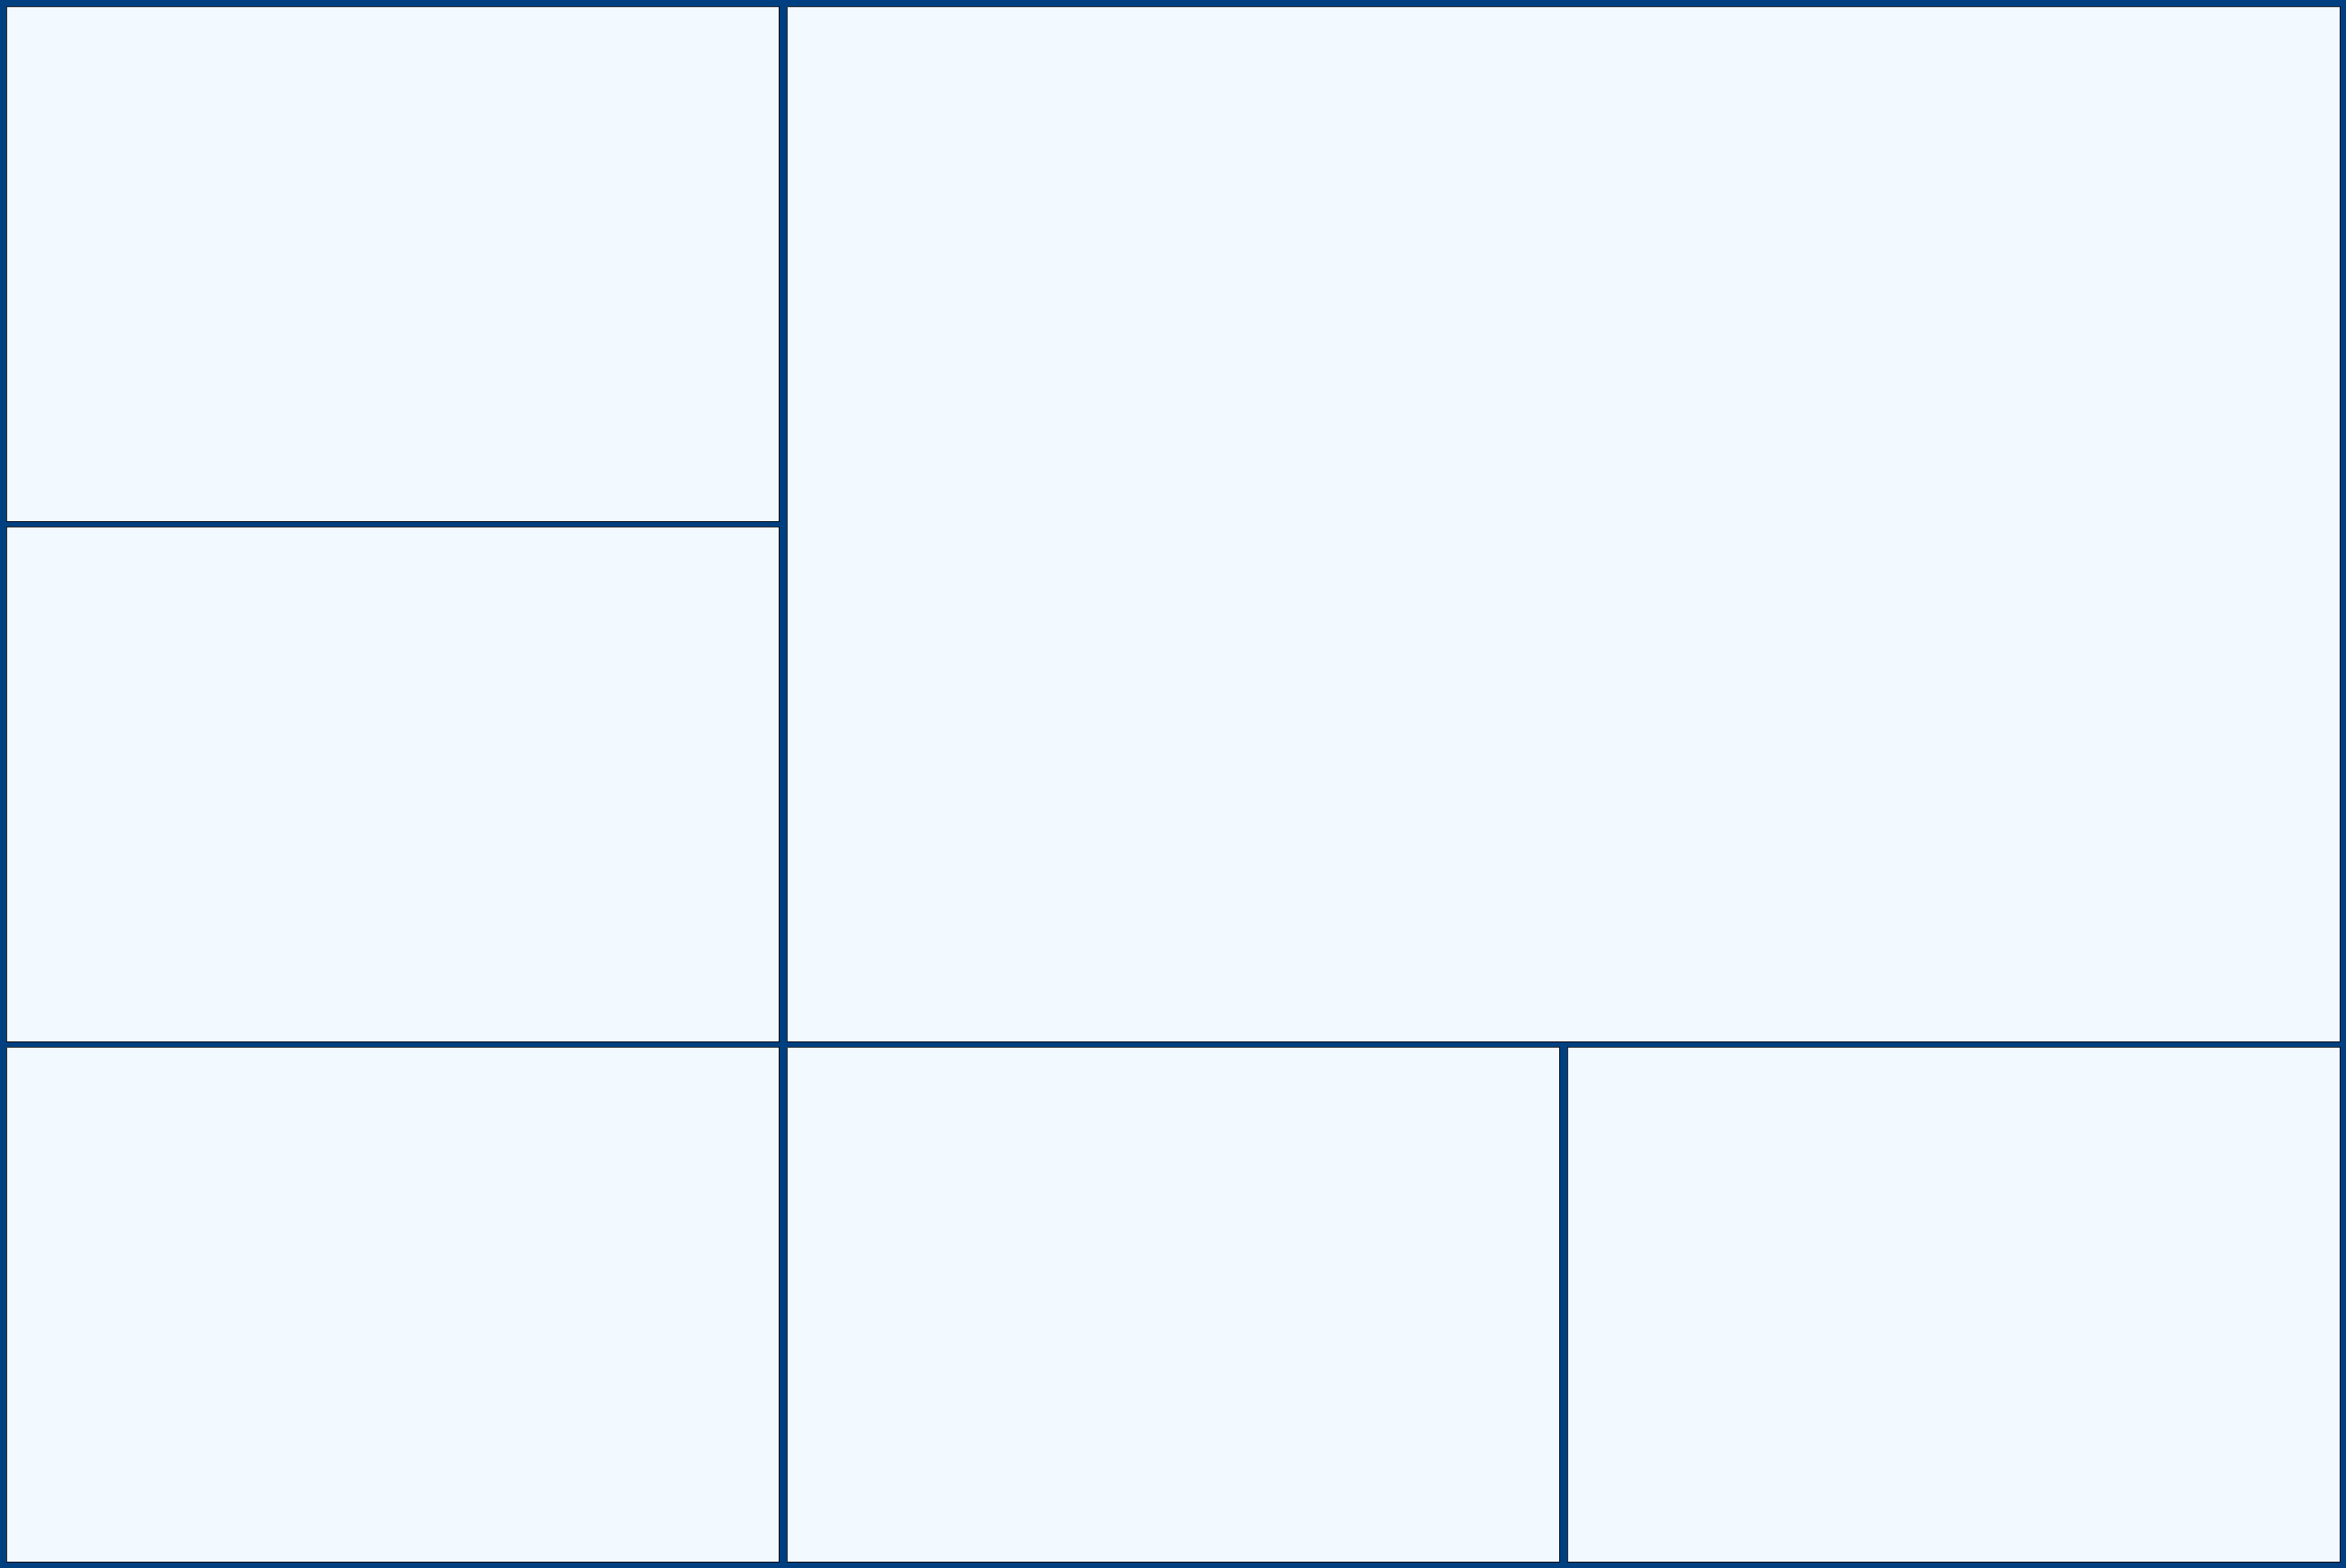

In [8]:
def make_layout():
    
    ## make segmented plotting space
    dash_figure = plt.figure(figsize = (36, 24))
    dash_figure.set_facecolor(set_color['Divider'])
    
    ## define axes
    dash_axis = dict()
    fig_grid = dash_figure.add_gridspec(3, 3, figure = dash_figure,
        hspace = 0.01, wspace = 0.01,
        left= 0, right = 1, bottom = 0, top = 1
        )
    dash_axis['intro'] = dash_figure.add_subplot(fig_grid[0, 0])
    dash_axis['progress'] = dash_figure.add_subplot(fig_grid[1, 0])
    dash_axis['opportunity'] = dash_figure.add_subplot(fig_grid[2, 0],
        projection = set_map['projection'])
    dash_axis['route'] = dash_figure.add_subplot(fig_grid[2, 1],
        projection = set_map['projection'])
    dash_axis['table'] = dash_figure.add_subplot(fig_grid[2, 2])
    dash_axis['travel'] = dash_figure.add_subplot(fig_grid[0:2,1:3],
        projection = set_map['projection'])
    
    ## find map extent
    dash_axis['travel'].set_extent(set_map['extent'])
    dash_axis['route'].set_extent(set_map['extent'])
    dash_axis['opportunity'].set_extent(set_map['extent'])
    
    ## remove axis ticks
    for i in dash_axis.keys():
        dash_axis[i].tick_params(
            labelbottom = False, labeltop = False,
            labelleft = False, labelright = False,
            bottom = False, top = False,
            left = False, right = False,
            color = set_color['Coast']
        )
        dash_axis[i].set_facecolor(set_color['Background'])
        
    return dash_figure, dash_axis

## save dashboard visualization to disk (run at end)
def save_dashboard(): 
    dash_figure.savefig("C_Output/us_travels.png")
    dash_figure.savefig("C_Output/us_travels.pdf")
    
## execute functions
dash_figure, dash_axis = make_layout()

# Non-Map Panels

### Progress Panel

### Table Panel

# Map Line Panels

### Route Panel

### Travel Panel

# Opportunity Panel

# Text Elements

### Intro Panel

### Titles

### Captions

# Testing

### Test 0

### Test 1

### Test 2

### Test 3

# Final Tasks

### Render Visualizations

In [9]:
## save_dashboard()

### Misc

In [10]:
time_check('[End]')


 Time Check [End]: 14:19:35 

